**Analysis of Rotator Trajectory and Controller**

**Import Modules**

In [1]:
%matplotlib inline
%matplotlib widget
from datetime import datetime
import time
from astropy.time import Time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lsst_efd_client import EfdClient

**Custom Functions**

In [2]:
def retrieve_efd_client(is_summit=True):
    """
    Retrieves a client to EFD.

    Parameters
    ----------
    is_summit : bool, optional
        This notebook is running on the summit or not. If not, the returned object will point
        to the test stand at Tucson.

    Returns
    -------
    EfdClient : The interface object between the Nublado and summit/Tucson EFD.
    """
    efd_name = "summit_efd" if is_summit else "tucson_teststand_efd"        
    return EfdClient(efd_name)

In [3]:
async def get_data_path_generator(efd_client, time_start, time_end):
    """
    Get the data of path generator.

    Parameters
    ----------
    efd_client : lsst_efd_client.efd_helper.EfdClient
        EFD client.
    time_start : astropy.time.core.Time
        Start time.
    time_end : astropy.time.core.Time
        End time.
        
    Returns
    -------
    data : pandas.core.frame.DataFram
        Data of the path generator.
    acceleration : numpy.ndarray
        Acceleration in deg/sec^2.
    jerk : numpy.ndarray
        Jerk in deg/sec^3.
    time_operation : numpy.ndarray
        Operation time.
    """
    # Get the data from EFD
    data = await efd_client.select_time_series(
        "lsst.sal.MTRotator.rotation", 
        fields=["demandPosition", "demandVelocity", "demandAcceleration", "actualPosition", "actualVelocity", "timestamp"], 
        start=time_start, 
        end=time_end)

    # Realign the time origin to 0
    time_operation = np.array(data.timestamp.subtract(data.timestamp[0]))

    # Calculate the acceleration and jerk
    # Note the Simulink model had applied the low-pass filter for the calculation of velocity already 
    acceleration, jerk = calc_acceleration_and_jerk(time_operation, data.actualVelocity)
    
    return data, acceleration, jerk, time_operation

In [4]:
def calc_acceleration_and_jerk(time, velocity):
    """
    Calculate the acceleratioin and jerk.

    Parameters
    ----------
    time : numpy.ndarray
        Time in second.
    velocity : pandas.core.series.Series
        velocity (deg/sec).

    Returns
    ----------
    acceleration : numpy.ndarray
        Acceleration in deg/sec^2.
    jerk : numpy.ndarray
        Jerk in deg/sec^3.
    """

    acceleration = np.gradient(velocity, time)
    jerk = np.gradient(acceleration, time)

    return acceleration, jerk

In [5]:
async def get_data_motors(efd_client, time_start, time_end):
    """
    Get the data of motor.

    Parameters
    ----------
    efd_client : lsst_efd_client.efd_helper.EfdClient
        EFD client.
    time_start : astropy.time.core.Time
        Start time.
    time_end : astropy.time.core.Time
        End time.

    Returns
    -------
    data : pandas.core.frame.DataFram
        Data of the motor.
    """
    # Get the data from EFD
    data = await efd_client.select_time_series(
        "lsst.sal.MTRotator.motors",
        fields=["torque0", "torque1", "current0", "current1", "busVoltage"],
        start=time_start,
        end=time_end)
    
    return data

In [6]:
def plot_currents(data, time_operation):
    """
    Plot the data of currents.

    Parameters
    -------
    data : pandas.core.frame.DataFram
        Data of the motor.
    time_operation : numpy.ndarray
        Operation time.
    """

    plt.figure()
    plt.plot(time_operation, data.current0, "b")
    plt.plot(time_operation, data.current1, "r")
    plt.title("Currents")
    plt.xlabel("Time (s)")
    plt.ylabel("Current (A)")

In [7]:
def plot_path_generator(data, acceleration, jerk, time_operation):
    """
    Plot the data of path generator.

    Parameters
    -------
    data : pandas.core.frame.DataFram
        Data of the path generator.
    acceleration : numpy.ndarray
        Acceleration in deg/sec^2.
    jerk : numpy.ndarray
        Jerk in deg/sec^3.
    time_operation : numpy.ndarray
        Operation time.
    """

    plt.figure()
    plt.subplot(5, 1, 1)
    plt.plot(time_operation, data.demandPosition)
    plt.plot(time_operation, data.actualPosition, "x-")
    plt.title("Path Generator")
    plt.ylabel("P")

    plt.subplot(5, 1, 2)
    plt.plot(time_operation, (data.demandPosition - data.actualPosition) * 3600)
    plt.ylabel("dP (arcsec)")

    plt.subplot(5, 1, 3)
    plt.plot(time_operation, data.demandVelocity)
    plt.plot(time_operation, data.actualVelocity, "x-")
    plt.ylabel("V")

    plt.subplot(5, 1, 4)
    plt.plot(time_operation, data.demandAcceleration)
    plt.plot(time_operation, acceleration, "x-")
    plt.ylabel("A")

    plt.subplot(5, 1, 5)
    plt.plot(time_operation, jerk)
    plt.ylabel("J")
    plt.xlabel("Time (s)")
    
    print("Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)")

In [8]:
def analyze_tracking_targets(data, time_operation, list_time_start, list_time_end):
    """
    Analyze the tracking target.

    Parameters
    -------
    data : pandas.core.frame.DataFram
        Data of the path generator.
    time_operation : numpy.ndarray
        Operation time.
    list_time_start : list
        List of the start time in second.
    list_time_end : list
        List of the end time in second.
    """

    rms_positions = list()
    for time_start, time_end in zip(list_time_start, list_time_end):
        rms_position = analyze_tracking_target(data, time_operation, time_start, time_end, show_figure=False)
        rms_positions.append(rms_position)
        print("\n")

    rms_positions_overall = np.sqrt(np.mean(np.array(rms_positions) ** 2))

    digit_after_decimal = 3
    print(f"The overall RMS of position error is {round(rms_positions_overall, digit_after_decimal)} arcsec.")

In [9]:
def analyze_tracking_target(data, time_operation, time_start, time_end, show_figure=True):
    """
    Analyze the tracking target.

    Parameters
    -------
    data : pandas.core.frame.DataFram
        Data of the path generator.
    time_operation : numpy.ndarray
        Operation time.
    time_start : float
        Start time in second.
    time_end : float
        End time in second.
    show_figure : bool, optional
        Show the figure or not. (the default is True)
    
    Returns
    -------
    rms_position : flost
        RMS of the position error.
    """

    # Get the position data within the time range (in arcsec)
    indices = np.where(np.logical_and(time_operation>=time_start, time_operation<=time_end))[0]
    position_demand = np.array(data.demandPosition[indices]) * 3600
    position_actual = np.array(data.actualPosition[indices]) * 3600
    
    # Analyze the data
    diff_position = position_demand - position_actual
    rms_position = np.sqrt(np.mean(diff_position ** 2))

    # Print the information
    digit_after_decimal = 3
    print(f"Analyze the data between {time_start} sec and {time_end} sec.")
    print(f"There are {len(indices)} points.")
    print(f"The max of position error is {round(np.max((np.abs(diff_position))), digit_after_decimal)} arcsec.")
    print(f"The RMS of position error is {round(rms_position, digit_after_decimal)} arcsec.")

    # Plot the figure
    if show_figure:
        plt.figure()
        plt.title("Position Error")
        plt.plot(time_operation[indices], diff_position)
        plt.xlabel("Time (s)")
        plt.ylabel("dP (arcsec)")
        
    return rms_position

In [10]:
async def get_event_data(efd_client, time_start, time_end):
    """
    Get the event data.

    Parameters
    ----------
    efd_client : lsst_efd_client.efd_helper.EfdClient
        EFD client.
    time_start : astropy.time.core.Time
        Start time.
    time_end : astropy.time.core.Time
        End time.

    Returns
    -------
    data_controller_state : pandas.core.frame.DataFrame
        Data of the controller state event.
    data_in_position : pandas.core.frame.DataFrame
        Data of the inPosition event.
    data_tracking : pandas.core.frame.DataFrame
        Data of the tracking event.
    """

    # Get the data from EFD
    data_controller_state = await efd_client.select_time_series(
        "lsst.sal.MTRotator.logevent_controllerState", 
        fields=["controllerState", "enabledSubstate"], 
        start=time_start,
        end=time_end)
    
    # The inPosition field is a combination of Flags_moveSuccess and Flags_trackingSuccess in Simulink telemetry
    data_in_position = await efd_client.select_time_series(
        "lsst.sal.MTRotator.logevent_inPosition", 
        fields="inPosition",
        start=time_start,
        end=time_end)
    
    # The tracking field is Flags_trackingSuccess in Simulink telemetry
    # The lost field is Flags_trackingLost in Simulink telemetry
    # The noNewCommand field is Flags_noNewTrackCmdError in Simulink telemetry
    data_tracking = await efd_client.select_time_series(
        "lsst.sal.MTRotator.logevent_tracking", 
        fields=["tracking", "lost", "noNewCommand"],
        start=time_start,
        end=time_end)

    # Add the column of time difference in seconds
    add_column_time_differece(data_controller_state, time_start)
    add_column_time_differece(data_in_position, time_start)
    add_column_time_differece(data_tracking, time_start)

    return data_controller_state, data_in_position, data_tracking

In [11]:
def add_column_time_differece(data_frame, time_start):
    """
    Add the column of time difference in second.

    Parameters
    ----------
    data_frame : pandas.core.frame.DataFrame
        Data frame.
    time_start : astropy.time.core.Time
        Start time.
    """
    if (len(data_frame.values) != 0):
        timestamp_start = pd.Timestamp(time_start.value, tz="utc")
        diff_time = data_frame.index - pd.Timestamp(time_start.value, tz="utc")
        diff_time_sec = [element.seconds + element.microseconds * 1e-6 for element in diff_time]
        data_frame["time_difference"] = diff_time_sec

In [12]:
def plot_event_in_position(data_path_generator, time_operation, data_in_position):
    """
    Plot the inPosition events.
    
    The vertical green line means the inPosition=Ture, otherwise the vertical red line.
    
    Parameters
    ----------
    data_path_generator : pandas.core.frame.DataFrame
        Data of the path generator.
    time_operation : numpy.ndarray
        Operation time.
    data_in_position : pandas.core.frame.DataFrame
        Data of the inPosition event.
    """

    plt.figure()
    plt.plot(time_operation, data.demandPosition)
    plt.plot(time_operation, data_path_generator.actualPosition, "x-")
    
    # Plot the inPosition event
    for inPosition, time_inPosition in zip(data_in_position.inPosition, data_in_position.time_difference):
        if inPosition:
            plt.axvline(x=time_inPosition, color="g")
        else:
            plt.axvline(x=time_inPosition, color="r")

    plt.xlabel("Time (s)")
    plt.ylabel("P (deg)")

In [13]:
def plot_event_tracking(data_path_generator, time_operation, data_tracking):
    """
    Plot the tracking events.
    
    The vertical yellow line means the tracking=True.
    The vertical cyan line means the tracking=False.
    The vertical black line means the noNewCommand=Ture.
    
    Parameters
    ----------
    data_path_generator : pandas.core.frame.DataFrame
        Data of the path generator.
    time_operation : numpy.ndarray
        Operation time.
    data_tracking : pandas.core.frame.DataFrame
        Data of the tracking event.
    """

    plt.figure()
    plt.plot(time_operation, data.demandPosition)
    plt.plot(time_operation, data_path_generator.actualPosition, "x-")
    
    # Plot the tracking event
    for tracking, noNewCommand, time_happen in zip(data_tracking.tracking, data_tracking.noNewCommand, data_tracking.time_difference):
        if tracking:
            plt.axvline(x=time_happen, color="y")
        else:
            plt.axvline(x=time_happen, color="c")

        if noNewCommand:
            plt.axvline(x=time_happen, color="k")

    plt.xlabel("Time (s)")
    plt.ylabel("P (deg)")

**Instantiate the EFD**

In [14]:
efd_client = retrieve_efd_client(is_summit=True)

**Baseline**

Note that we need to add **4** hours more manually to query EFD data when checking the data from Chronograf.
For example, if I need a data at `2022-05-20T12:54:00`, the `Time("2022-05-20T16:54:00", scale="utc", format="isot")` is used.

In [77]:
time_start = Time("2022-06-02T15:03:49", scale="utc", format="isot")
time_end = Time("2022-06-02T15:14:20", scale="utc", format="isot")

In [78]:
data, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


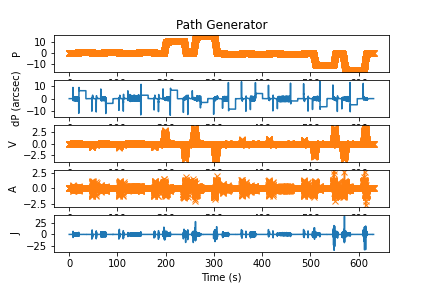

In [84]:
plot_path_generator(data, acceleration, jerk, time_operation)

Text(0, 0.5, 'Position (deg)')

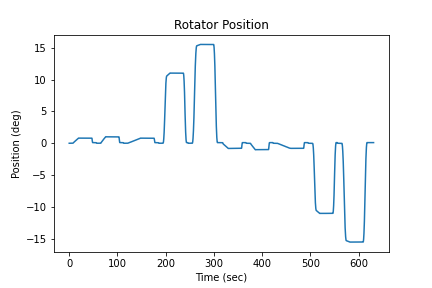

In [85]:
plt.figure()
plt.plot(time_operation, data.actualPosition)
plt.title("Rotator Position")
plt.xlabel("Time (sec)")
plt.ylabel("Position (deg)")

Check the data in a smaller range.

In [90]:
time_start = Time("2022-06-02T15:05:43", scale="utc", format="isot")
time_end = Time("2022-06-02T15:06:53", scale="utc", format="isot")

In [91]:
data_path, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)
data_motor = await get_data_motors(efd_client, time_start, time_end)

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


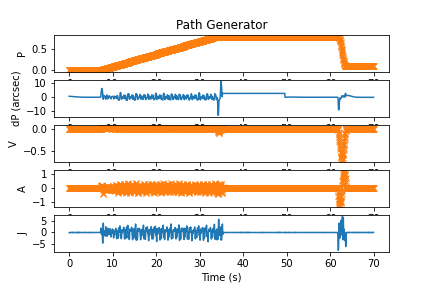

In [92]:
plot_path_generator(data_path, acceleration, jerk, time_operation)

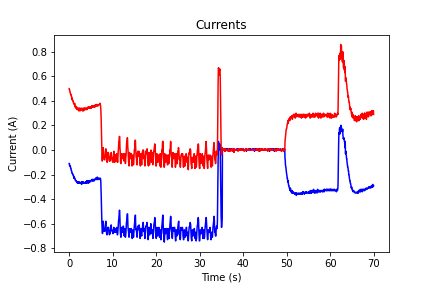

In [93]:
plot_currents(data_motor, time_operation)

Analyze the data between 8.7 sec and 19 sec.
There are 206 points.
The max of position error is 1.846 arcsec.
The RMS of position error is 1.006 arcsec.


1.006252321367831

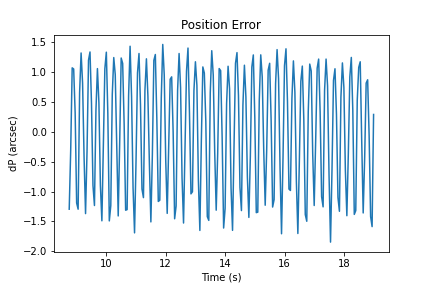

In [24]:
analyze_tracking_target(data_path, time_operation, 8.7, 19, show_figure=True)

In [41]:
plt.close("all")

Analyze all the data

In [25]:
time_start = Time("2022-06-02T15:03:49", scale="utc", format="isot")
time_end = Time("2022-06-02T15:14:20", scale="utc", format="isot")
data_path, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)

list_time_start = [8.5, 67.045, 126, 202, 264, 319, 377, 436, 512, 575]
list_time_end = [18.45, 74.39, 147, 208, 271, 329, 385, 457, 518, 581]
analyze_tracking_targets(data_path, time_operation, list_time_start, list_time_end)

Analyze the data between 8.5 sec and 18.45 sec.
There are 199 points.
The max of position error is 1.846 arcsec.
The RMS of position error is 1.006 arcsec.


Analyze the data between 67.045 sec and 74.39 sec.
There are 146 points.
The max of position error is 1.77 arcsec.
The RMS of position error is 0.967 arcsec.


Analyze the data between 126 sec and 147 sec.
There are 420 points.
The max of position error is 3.148 arcsec.
The RMS of position error is 1.278 arcsec.


Analyze the data between 202 sec and 208 sec.
There are 120 points.
The max of position error is 1.655 arcsec.
The RMS of position error is 0.905 arcsec.


Analyze the data between 264 sec and 271 sec.
There are 140 points.
The max of position error is 2.258 arcsec.
The RMS of position error is 1.146 arcsec.


Analyze the data between 319 sec and 329 sec.
There are 200 points.
The max of position error is 2.105 arcsec.
The RMS of position error is 1.109 arcsec.


Analyze the data between 377 sec and 385 sec.
There are 16

**Increase 25%**

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


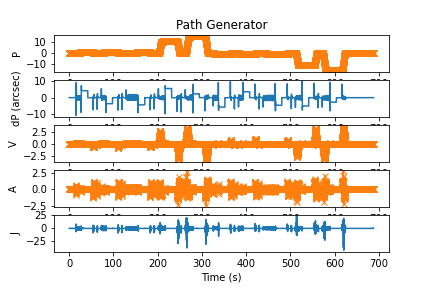

In [27]:
time_start = Time("2022-06-02T15:21:44", scale="utc", format="isot")
time_end = Time("2022-06-02T15:33:12", scale="utc", format="isot")

data_path, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)
data_motor = await get_data_motors(efd_client, time_start, time_end)

plot_path_generator(data_path, acceleration, jerk, time_operation)

Text(0, 0.5, 'Position (deg)')

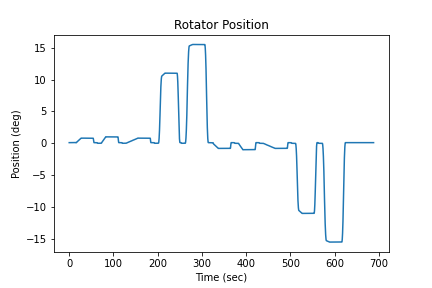

In [29]:
plt.figure()
plt.plot(time_operation, data_path.actualPosition)
plt.title("Rotator Position")
plt.xlabel("Time (sec)")
plt.ylabel("Position (deg)")

In [31]:
list_time_start = [17, 74, 131, 209, 272, 326, 384, 443, 520, 582]
list_time_end = [26, 82, 153, 215, 278, 336, 392, 462, 525, 588]
analyze_tracking_targets(data_path, time_operation, list_time_start, list_time_end)

Analyze the data between 17 sec and 26 sec.
There are 180 points.
The max of position error is 1.367 arcsec.
The RMS of position error is 0.75 arcsec.


Analyze the data between 74 sec and 82 sec.
There are 160 points.
The max of position error is 1.206 arcsec.
The RMS of position error is 0.733 arcsec.


Analyze the data between 131 sec and 153 sec.
There are 440 points.
The max of position error is 1.954 arcsec.
The RMS of position error is 0.902 arcsec.


Analyze the data between 209 sec and 215 sec.
There are 120 points.
The max of position error is 1.229 arcsec.
The RMS of position error is 0.662 arcsec.


Analyze the data between 272 sec and 278 sec.
There are 120 points.
The max of position error is 1.801 arcsec.
The RMS of position error is 0.78 arcsec.


Analyze the data between 326 sec and 336 sec.
There are 200 points.
The max of position error is 1.593 arcsec.
The RMS of position error is 0.834 arcsec.


Analyze the data between 384 sec and 392 sec.
There are 160 points.
Th

**Increase 50%**

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


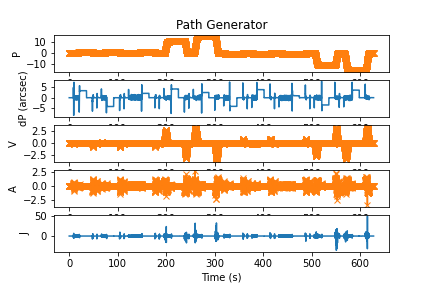

In [34]:
time_start = Time("2022-06-02T15:36:02", scale="utc", format="isot")
time_end = Time("2022-06-02T15:46:30", scale="utc", format="isot")

data_path, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)
data_motor = await get_data_motors(efd_client, time_start, time_end)

plot_path_generator(data_path, acceleration, jerk, time_operation)

Text(0, 0.5, 'Position (deg)')

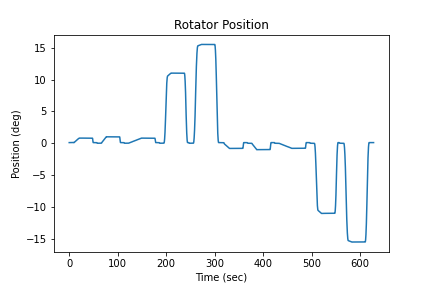

In [35]:
plt.figure()
plt.plot(time_operation, data_path.actualPosition)
plt.title("Rotator Position")
plt.xlabel("Time (sec)")
plt.ylabel("Position (deg)")

In [36]:
list_time_start = [10, 68, 128, 203, 266, 320, 378, 438, 514, 576]
list_time_end = [19, 76, 147, 209, 272, 330, 386, 457, 519, 583]
analyze_tracking_targets(data_path, time_operation, list_time_start, list_time_end)

Analyze the data between 10 sec and 19 sec.
There are 180 points.
The max of position error is 1.085 arcsec.
The RMS of position error is 0.583 arcsec.


Analyze the data between 68 sec and 76 sec.
There are 160 points.
The max of position error is 0.975 arcsec.
The RMS of position error is 0.568 arcsec.


Analyze the data between 128 sec and 147 sec.
There are 380 points.
The max of position error is 1.522 arcsec.
The RMS of position error is 0.688 arcsec.


Analyze the data between 203 sec and 209 sec.
There are 120 points.
The max of position error is 0.961 arcsec.
The RMS of position error is 0.505 arcsec.


Analyze the data between 266 sec and 272 sec.
There are 120 points.
The max of position error is 1.368 arcsec.
The RMS of position error is 0.593 arcsec.


Analyze the data between 320 sec and 330 sec.
There are 200 points.
The max of position error is 1.274 arcsec.
The RMS of position error is 0.666 arcsec.


Analyze the data between 378 sec and 386 sec.
There are 160 points.


**Increase 75%**

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


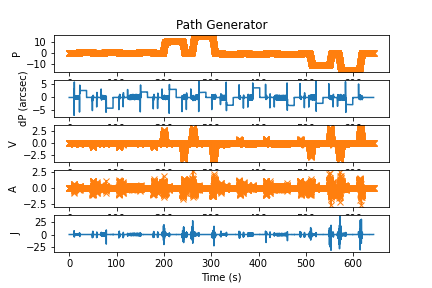

In [67]:
time_start = Time("2022-06-02T15:50:47", scale="utc", format="isot")
time_end = Time("2022-06-02T16:01:30", scale="utc", format="isot")

data_path, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)
data_motor = await get_data_motors(efd_client, time_start, time_end)

plot_path_generator(data_path, acceleration, jerk, time_operation)

Text(0, 0.5, 'Position (deg)')

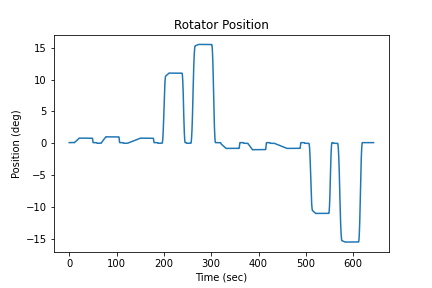

In [70]:
plt.figure()
plt.plot(time_operation, data_path.actualPosition)
plt.title("Rotator Position")
plt.xlabel("Time (sec)")
plt.ylabel("Position (deg)")

In [71]:
list_time_start = [12, 69, 128, 204, 267, 321, 379, 439, 514, 577]
list_time_end = [20, 77, 148, 210, 272, 330, 387, 458, 520, 583]
analyze_tracking_targets(data_path, time_operation, list_time_start, list_time_end)

Analyze the data between 12 sec and 20 sec.
There are 160 points.
The max of position error is 0.735 arcsec.
The RMS of position error is 0.46 arcsec.


Analyze the data between 69 sec and 77 sec.
There are 160 points.
The max of position error is 0.762 arcsec.
The RMS of position error is 0.459 arcsec.


Analyze the data between 128 sec and 148 sec.
There are 400 points.
The max of position error is 1.203 arcsec.
The RMS of position error is 0.529 arcsec.


Analyze the data between 204 sec and 210 sec.
There are 120 points.
The max of position error is 0.75 arcsec.
The RMS of position error is 0.395 arcsec.


Analyze the data between 267 sec and 272 sec.
There are 100 points.
The max of position error is 1.08 arcsec.
The RMS of position error is 0.493 arcsec.


Analyze the data between 321 sec and 330 sec.
There are 180 points.
The max of position error is 1.023 arcsec.
The RMS of position error is 0.542 arcsec.


Analyze the data between 379 sec and 387 sec.
There are 160 points.
The

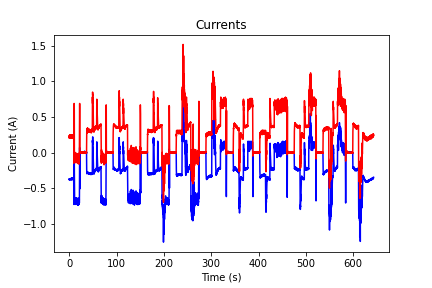

In [72]:
plot_currents(data_motor, time_operation)

**Increase 100%**

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


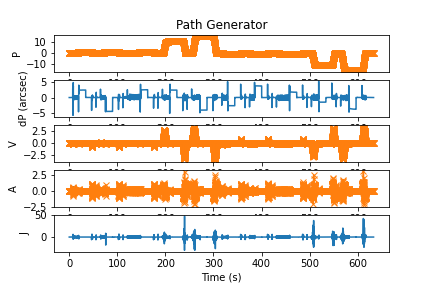

In [63]:
time_start = Time("2022-06-02T16:03:42", scale="utc", format="isot")
time_end = Time("2022-06-02T16:14:15", scale="utc", format="isot")

data_path, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)
data_motor = await get_data_motors(efd_client, time_start, time_end)

plot_path_generator(data_path, acceleration, jerk, time_operation)

Text(0, 0.5, 'Position (deg)')

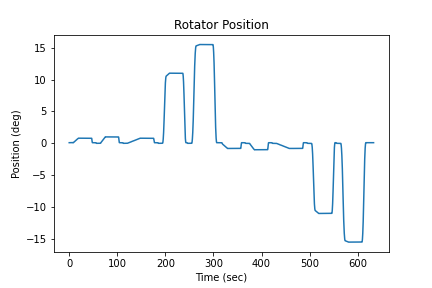

In [64]:
plt.figure()
plt.plot(time_operation, data_path.actualPosition)
plt.title("Rotator Position")
plt.xlabel("Time (sec)")
plt.ylabel("Position (deg)")

In [65]:
list_time_start = [9, 67, 126, 202, 264, 319, 376, 435, 512, 574]
list_time_end = [18, 74, 146, 208, 271, 328, 384, 455, 518, 580]
analyze_tracking_targets(data_path, time_operation, list_time_start, list_time_end)

Analyze the data between 9 sec and 18 sec.
There are 180 points.
The max of position error is 0.735 arcsec.
The RMS of position error is 0.37 arcsec.


Analyze the data between 67 sec and 74 sec.
There are 140 points.
The max of position error is 0.638 arcsec.
The RMS of position error is 0.379 arcsec.


Analyze the data between 126 sec and 146 sec.
There are 400 points.
The max of position error is 1.108 arcsec.
The RMS of position error is 0.44 arcsec.


Analyze the data between 202 sec and 208 sec.
There are 120 points.
The max of position error is 0.58 arcsec.
The RMS of position error is 0.31 arcsec.


Analyze the data between 264 sec and 271 sec.
There are 140 points.
The max of position error is 0.935 arcsec.
The RMS of position error is 0.383 arcsec.


Analyze the data between 319 sec and 328 sec.
There are 180 points.
The max of position error is 0.85 arcsec.
The RMS of position error is 0.448 arcsec.


Analyze the data between 376 sec and 384 sec.
There are 160 points.
The ma

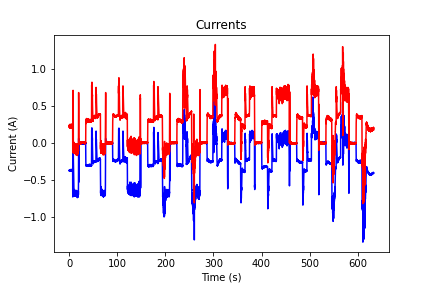

In [66]:
plot_currents(data_motor, time_operation)

**Increase 125%**

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


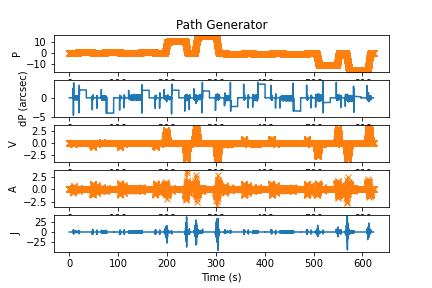

In [73]:
time_start = Time("2022-06-02T16:17:27", scale="utc", format="isot")
time_end = Time("2022-06-02T16:27:50", scale="utc", format="isot")

data_path, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)
data_motor = await get_data_motors(efd_client, time_start, time_end)

plot_path_generator(data_path, acceleration, jerk, time_operation)

Text(0, 0.5, 'Position (deg)')

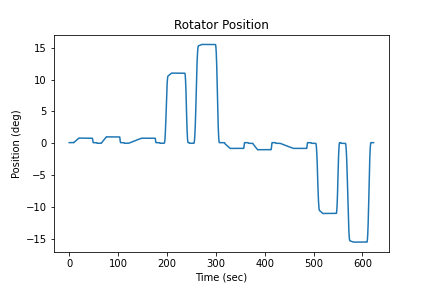

In [74]:
plt.figure()
plt.plot(time_operation, data_path.actualPosition)
plt.title("Rotator Position")
plt.xlabel("Time (sec)")
plt.ylabel("Position (deg)")

In [75]:
list_time_start = [10, 67, 126, 202, 265, 320, 377, 436, 513, 575]
list_time_end = [19, 75, 146, 208, 271, 329, 385, 457, 518, 581]
analyze_tracking_targets(data_path, time_operation, list_time_start, list_time_end)

Analyze the data between 10 sec and 19 sec.
There are 180 points.
The max of position error is 0.54 arcsec.
The RMS of position error is 0.305 arcsec.


Analyze the data between 67 sec and 75 sec.
There are 160 points.
The max of position error is 0.627 arcsec.
The RMS of position error is 0.326 arcsec.


Analyze the data between 126 sec and 146 sec.
There are 400 points.
The max of position error is 0.921 arcsec.
The RMS of position error is 0.365 arcsec.


Analyze the data between 202 sec and 208 sec.
There are 120 points.
The max of position error is 0.787 arcsec.
The RMS of position error is 0.258 arcsec.


Analyze the data between 265 sec and 271 sec.
There are 120 points.
The max of position error is 0.88 arcsec.
The RMS of position error is 0.334 arcsec.


Analyze the data between 320 sec and 329 sec.
There are 180 points.
The max of position error is 0.761 arcsec.
The RMS of position error is 0.375 arcsec.


Analyze the data between 377 sec and 385 sec.
There are 160 points.
Th

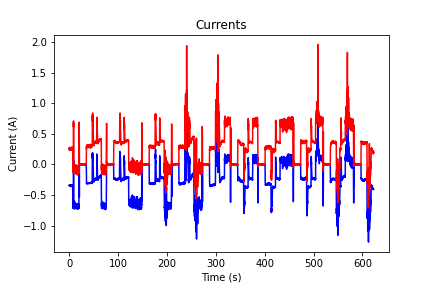

In [76]:
plot_currents(data_motor, time_operation)

Check the data in a smaller range.

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


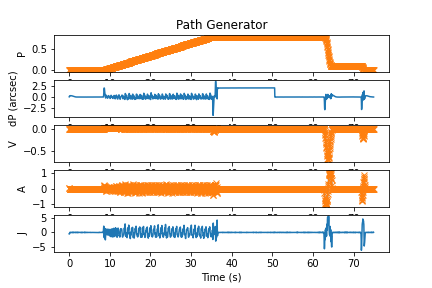

In [98]:
time_start = Time("2022-06-02T16:19:20", scale="utc", format="isot")
time_end = Time("2022-06-02T16:20:35", scale="utc", format="isot")

data_path, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)
data_motor = await get_data_motors(efd_client, time_start, time_end)

plot_path_generator(data_path, acceleration, jerk, time_operation)

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


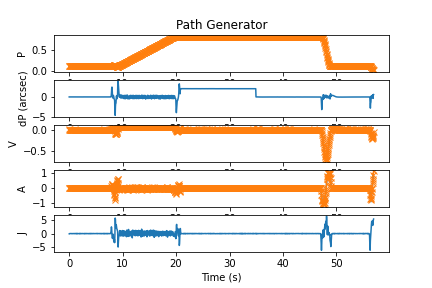

In [99]:
time_start = Time("2022-06-02T16:17:27", scale="utc", format="isot")
time_end = Time("2022-06-02T16:18:24", scale="utc", format="isot")

data_path, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)
data_motor = await get_data_motors(efd_client, time_start, time_end)

plot_path_generator(data_path, acceleration, jerk, time_operation)

**Increase 150%**

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


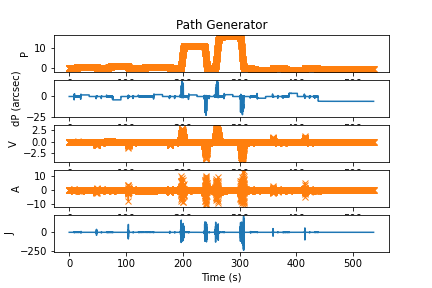

In [59]:
time_start = Time("2022-06-02T16:30:04", scale="utc", format="isot")
time_end = Time("2022-06-02T16:39:00", scale="utc", format="isot")

data_path, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)
data_motor = await get_data_motors(efd_client, time_start, time_end)

plot_path_generator(data_path, acceleration, jerk, time_operation)

Text(0, 0.5, 'Position (deg)')

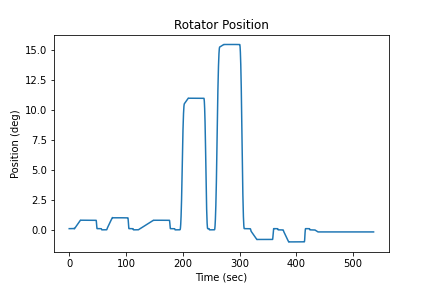

In [60]:
plt.figure()
plt.plot(time_operation, data_path.actualPosition)
plt.title("Rotator Position")
plt.xlabel("Time (sec)")
plt.ylabel("Position (deg)")

In [61]:
list_time_start = [10, 67, 127, 203, 265, 320, 378]
list_time_end = [19, 75, 147, 209, 271, 330, 386]
analyze_tracking_targets(data_path, time_operation, list_time_start, list_time_end)

Analyze the data between 10 sec and 19 sec.
There are 180 points.
The max of position error is 0.458 arcsec.
The RMS of position error is 0.253 arcsec.


Analyze the data between 67 sec and 75 sec.
There are 160 points.
The max of position error is 0.508 arcsec.
The RMS of position error is 0.276 arcsec.


Analyze the data between 127 sec and 147 sec.
There are 400 points.
The max of position error is 0.787 arcsec.
The RMS of position error is 0.311 arcsec.


Analyze the data between 203 sec and 209 sec.
There are 120 points.
The max of position error is 0.39 arcsec.
The RMS of position error is 0.211 arcsec.


Analyze the data between 265 sec and 271 sec.
There are 120 points.
The max of position error is 0.817 arcsec.
The RMS of position error is 0.301 arcsec.


Analyze the data between 320 sec and 330 sec.
There are 200 points.
The max of position error is 0.65 arcsec.
The RMS of position error is 0.323 arcsec.


Analyze the data between 378 sec and 386 sec.
There are 160 points.
Th

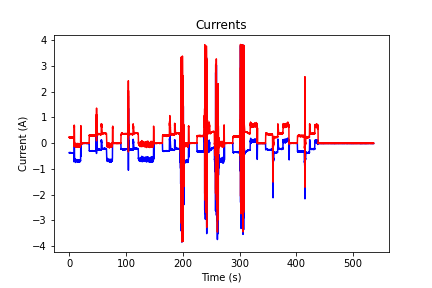

In [62]:
plot_currents(data_motor, time_operation)

**Increase 175%**

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


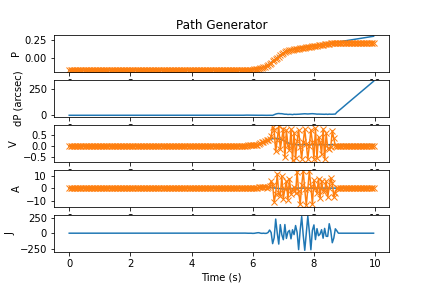

In [57]:
time_start = Time("2022-06-02T16:44:00", scale="utc", format="isot")
time_end = Time("2022-06-02T16:44:10", scale="utc", format="isot")

data_path, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)
data_motor = await get_data_motors(efd_client, time_start, time_end)

plot_path_generator(data_path, acceleration, jerk, time_operation)

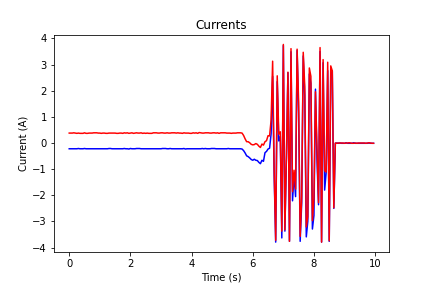

In [58]:
plot_currents(data_motor, time_operation)